In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def train_model(x, y, border_mode='same', inp_len=100, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model

In [3]:
def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr100', seq_len=100):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [4]:
df1 = pd.read_pickle('varying_length_25to100_1.pkl')
df = df1[df1['set']=='random']
print len(df)
## Filter out UTRs with too few less reads
df=df[df['total_reads']>=10]
print len(df)
df['utr100'] = 75*'N' +df['utr']
df['utr100'] = df['utr100'].str[-100:]
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)

87000
83919


In [5]:
human = df1[df1['set']=='human']
print len(human)
## Filter out UTRs with too few less reads
human=human[human['total_reads']>=10]
print len(human)
human['utr100'] = 75*'N' +human['utr']
human['utr100'] = human['utr100'].str[-100:]
human.sort_values('total_reads', inplace=True, ascending=False)
human.reset_index(inplace=True, drop=True)

16739
15555


## Take the top 100 UTRs with most sequencing reads at each length from 25 to 100nt as the test set.

In [36]:
e_test = pd.DataFrame(columns=df.columns)
for i in range(25,101):
    tmp = df[df['len']==i]
    tmp.sort_values('total_reads', inplace=True, ascending=False)
    tmp.reset_index(inplace=True, drop=True)
    e_test = e_test.append(tmp.iloc[:100])
print len(e_test)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7600


In [7]:
subhuman = pd.DataFrame(columns=human.columns)
for i in range(25,101):
    tmp = human[human['len']==i]
    tmp.sort_values('total_reads', inplace=True, ascending=False)
    tmp.reset_index(inplace=True, drop=True)
    subhuman = subhuman.append(tmp.iloc[:100])
print len(subhuman)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7600


### Used the held-out random sequences as the traing set.

In [8]:
e_train = pd.concat([df, e_test, e_test]).drop_duplicates(keep=False)
print len(e_train)

76319


In [37]:
# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=100)
seq_e_test = one_hot_encode(e_test, seq_len=100)

# Scale the training mean ribosome load values
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].reshape(-1,1))

In [130]:
model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
                   inp_len=100, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.2)

Epoch 1/3
76319/76319 [==============================] - 77s 1ms/step - loss: 0.5213
Epoch 2/3
76319/76319 [==============================] - 77s 1ms/step - loss: 0.3078
Epoch 3/3
76319/76319 [==============================] - 76s 989us/step - loss: 0.2630


In [ ]:
model.save('Varying_length_25to100_model.hdf5')

In [34]:
model = keras.models.load_model('Varying_length_25to100_model.hdf5')

In [38]:
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.8376560383135313


In [39]:
seq_e_test = one_hot_encode(subhuman, seq_len=100)
sub_human = test_data(df=subhuman, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(subhuman['rl'], subhuman['pred'])
print 'r-squared = ', r

r-squared =  0.7778260561473255


In [14]:
bins = np.arange(24, 105, 20)
labels = [ '25-44' , '45-64', '65-84', '85-100']

e_test['rng'] = pd.cut(e_test['len'], bins=bins)

In [15]:
bins = np.arange(24, 105, 20)
labels = [ '25-44' , '45-64', '65-84', '85-100']
subhuman['rng'] = pd.cut(subhuman['len'], bins=bins)

In [16]:
df_24_44=e_test[e_test['rng']=='(24, 44]']
df_44_64=e_test[e_test['rng']=='(44, 64]']
df_64_84=e_test[e_test['rng']=='(64, 84]']
df_84_104=e_test[e_test['rng']=='(84, 104]']

In [17]:
human_24_44=subhuman[subhuman['rng']=='(24, 44]']
human_44_64=subhuman[subhuman['rng']=='(44, 64]']
human_64_84=subhuman[subhuman['rng']=='(64, 84]']
human_84_104=subhuman[subhuman['rng']=='(84, 104]']

In [18]:
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth']= 1

In [19]:
sub1 = pd.concat([df_24_44,human_24_44])
sub2 = pd.concat([df_44_64,human_44_64])
sub3 = pd.concat([df_64_84,human_64_84])
sub4 = pd.concat([df_84_104,human_84_104])

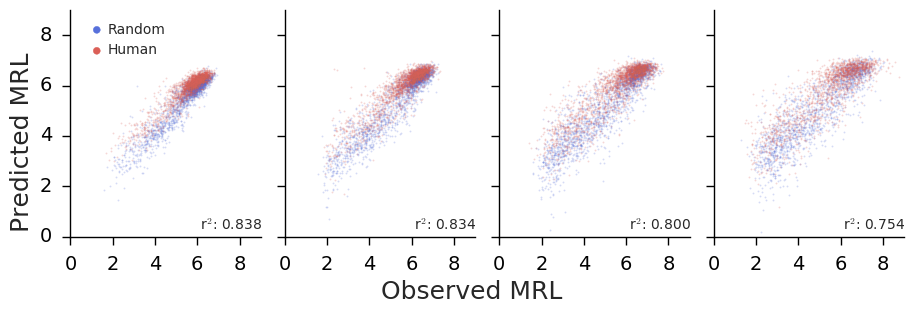

In [20]:
c1 = sns.color_palette("hls", 8)[0]
c2 = sns.color_palette("hls", 8)[5]
f, ([ax0, ax1, ax2, ax3]) = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
f.set_size_inches(9,3)

ax0.scatter(df_24_44.loc[:, 'rl'], df_24_44.loc[:, 'pred'], alpha=0.2, s=1, color = c2, label = 'Random')
ax1.scatter(df_44_64.loc[:, 'rl'], df_44_64.loc[:, 'pred'], alpha=0.2, s=1, color = c2)
ax2.scatter(df_64_84.loc[:, 'rl'], df_64_84.loc[:, 'pred'], alpha=0.2, s=1, color = c2)
ax3.scatter(df_84_104.loc[:, 'rl'], df_84_104.loc[:, 'pred'], alpha=0.2, s=1, color = c2)
ax0.scatter(human_24_44.loc[:, 'rl'], human_24_44.loc[:, 'pred'], alpha=0.2, s=1, color = c1, label = 'Human')
ax1.scatter(human_44_64.loc[:, 'rl'], human_44_64.loc[:, 'pred'], alpha=0.2, s=1, color = c1)
ax2.scatter(human_64_84.loc[:, 'rl'], human_64_84.loc[:, 'pred'], alpha=0.2, s=1, color = c1)
ax3.scatter(human_84_104.loc[:, 'rl'], human_84_104.loc[:, 'pred'], alpha=0.2, s=1, color = c1)
#ax0.set_title('N$_{25}$ - N$_{44}$', size = 20)
#ax1.set_title('N$_{45}$ - N$_{64}$', size = 20)
#ax2.set_title('N$_{65}$ - N$_{84}$', size = 20)
#ax3.set_title('N$_{85}$ - N$_{100}$', size = 20)

ax0.set_xlim(0,9)
ax0.set_xticks(range(0,9,2))
ax0.set_ylim(0,9)
ax0.set_yticks(range(0,9,2))

ax0.text(x=.68, y=0.03, s='r$^2$: ' + str(round(r2(sub1['rl'], sub1['pred']), 3)), transform=ax0.transAxes,size = 10)
ax1.text(x=.68, y=0.03, s='r$^2$: ' + str(round(r2(sub2['rl'], sub2['pred']), 3)), transform=ax1.transAxes,size = 10)
ax2.text(x=.68, y=0.03, s='r$^2$: ' + "%.3f" %(round(r2(sub3['rl'], sub3['pred']), 3)), transform=ax2.transAxes,size = 10)
ax3.text(x=.68, y=0.03, s='r$^2$: ' + str(round(r2(sub4['rl'],sub4['pred']), 3)), transform=ax3.transAxes,size = 10)
leg = ax0.legend(loc='upper left', fontsize=10, handletextpad=-0.2, markerscale=5)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

f.text(0.5, 0.0, 'Observed MRL', ha='center', va='center', size = 18)
f.text(0.0, 0.5, 'Predicted MRL', ha='center', va='center', rotation='vertical', size = 18)
f.tight_layout(h_pad=0.3)
sns.despine()

In [ ]:
f.savefig('Length_dependent_performance.eps', bbox_inches = 'tight',pad_inches=0)

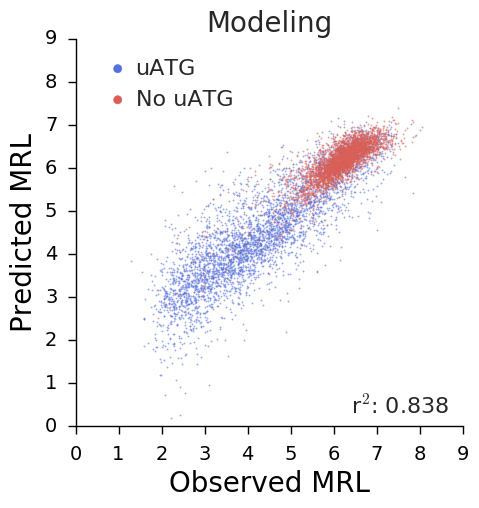

In [21]:
c1 = sns.color_palette("hls", 8)[0]
c2 = sns.color_palette("hls", 8)[5]
atg = e_test[e_test['utr'].apply(lambda x: 'ATG' in x)]
n_atg = e_test[e_test['utr'].apply(lambda x: 'ATG' not in x)]
r_squared = r2(e_test['rl'], e_test['pred'])
atg_obs = atg.loc[:, 'rl']
atg_pred = atg.loc[:, 'pred']

n_atg_obs = n_atg.loc[:, 'rl']
n_atg_pred = n_atg.loc[:, 'pred']

f, ax = plt.subplots()
f.set_size_inches((5,5))
ax.scatter(atg_obs, atg_pred, alpha=0.5, color=c2, label='uATG', s=1)
ax.scatter(n_atg_obs, n_atg_pred, alpha=0.5, color=c1, label='No uATG', s=1)
ax.set_xlabel('Observed MRL', size=20)
ax.set_ylabel('Predicted MRL', size=20)
ax.text(x=.71, y=0.03,s='r$^2$: ' + str(round(r_squared, 3)), transform=ax.transAxes, size=16)
ax.set_ylim((0, 9))
ax.set_title('Modeling', size = 20)
leg = ax.legend(loc='upper left', fontsize=16, handletextpad=-0.2, markerscale=6)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
sns.despine();

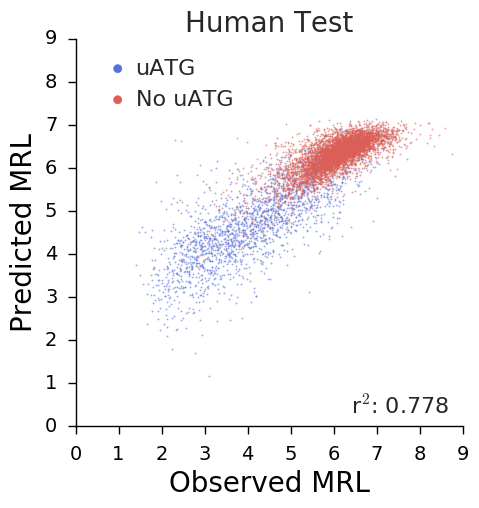

In [22]:
c1 = sns.color_palette("hls", 8)[0]
c2 = sns.color_palette("hls", 8)[5]
atg = subhuman[subhuman['utr'].apply(lambda x: 'ATG' in x)]
n_atg = subhuman[subhuman['utr'].apply(lambda x: 'ATG' not in x)]
r_squared = r2(subhuman['rl'], subhuman['pred'])
atg_obs = atg.loc[:, 'rl']
atg_pred = atg.loc[:, 'pred']

n_atg_obs = n_atg.loc[:, 'rl']
n_atg_pred = n_atg.loc[:, 'pred']

f, ax = plt.subplots()
f.set_size_inches((5,5))
ax.scatter(atg_obs, atg_pred, alpha=0.5, color=c2, label='uATG', s=1)
ax.scatter(n_atg_obs, n_atg_pred, alpha=0.5, color=c1, label='No uATG', s=1)
ax.set_xlabel('Observed MRL', size=20)
ax.set_ylabel('Predicted MRL', size=20)
ax.text(x=.71, y=0.03,s='r$^2$: ' + str(round(r_squared, 3)), transform=ax.transAxes, size=16)
ax.set_ylim((0, 9))
ax.set_xlim((0, 9))
ax.set_title('Human Test', size = 20)
leg = ax.legend(loc='upper left', fontsize=16, handletextpad=-0.2, markerscale=6)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
sns.despine();

## Fit the coupling efficiency on total reads in terms of UTR length

In [23]:
bins = np.arange(24, 105, 10)
labels = [ '25-34' , '35-44', '45-54', '55-64', '65-74', '75-84', '85-94','95-100']


e_test['rng'] = pd.cut(e_test['len'], bins=bins)
e_test['r_reads'] = e_test['total_reads']/float(max(e_test['total_reads']))

In [24]:
def func(x,r,a):
    return a*(r**x)
from scipy.optimize import curve_fit
medians = e_test.groupby(['rng'])['r_reads'].median().values
med = []
for i in medians:
    med.append(i)
length = np.arange(27.5, 105, 10)
popt,pcov = curve_fit(func, length, med)
mi = pd.DataFrame({'length':length, 'eff':func(length,*popt)})
print popt

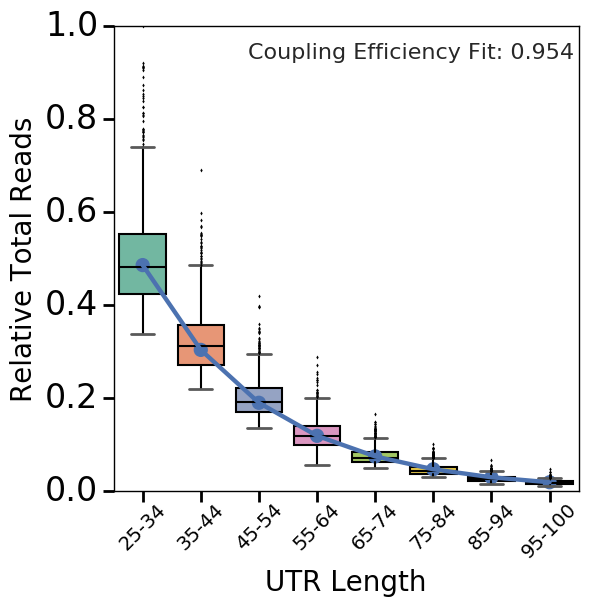

In [26]:
ax = sns.boxplot(y='r_reads',x='rng', data=e_test, palette=sns.color_palette("Set2", len(labels)),
                linewidth=2, boxprops={'edgecolor':'black','linewidth':1.5}, medianprops={'color':'black', 'linewidth':'1.5'},
                whiskerprops={'color':'black', 'linewidth':1.5}, flierprops={'markerfacecolor':'black', 'markersize':2,
                                                                           'linestyle':'none'})
ax.get_lines()
f = ax.get_figure()
sns.pointplot(x='length', y='eff', data=mi, ax = ax)


f.set_size_inches((6,6))
ax.set_xticks(range(0,len(labels)))
ax.set_xticklabels(labels, rotation=45, size=14,horizontalalignment='center');
ax.set_ylabel('Relative Total Reads', size=20)
ax.set_xlabel('UTR Length', size=20)
ax.set_ylim(0,1)

ax.text(x=.29, y=0.93,s='Coupling Efficiency Fit: ' + str(round(popt[0], 3)), transform=ax.transAxes, size=16)
ax.tick_params(axis='x', which='major', top=False, bottom=True, labelbottom=True, length=8, pad=0, width=2)
ax.tick_params(axis='y', which='major', right=False, length=8, pad=5, labelsize=24, width=2)

In [28]:
f.savefig('coupling.pdf', bbox_inches = 'tight',pad_inches=0)

## Length dependent statistics

In [27]:
def inframe_aug_vector(utr, kozak_len, exclude_inframe_stop, codon='ATG'):
    frame = 0-len(utr)%3
    cds = 'ATGGG'
    #cds = ''
    for i in xrange(0, len(utr) - 2):         
        if frame == -1:
            if utr[i:i+3] == codon:
                if (i + len(cds) > len(utr)):
                    cds_to_add = cds[:i + len(cds) - len(utr)]
                    stop_info = find_stop(utr, i)
                    return -1, utr[i-kozak_len:len(utr)+1] + cds_to_add, stop_info[0], stop_info[1], i
                else:
                    stop_info = find_stop(utr, i)
                    return -1, utr[i-kozak_len:i + len(cds)], stop_info[0], stop_info[1], i

            frame += 1
            continue
        
        if frame == -2:
            if utr[i:i+3] == codon:
                if (i + len(cds) > len(utr)):
                    cds_to_add = cds[:i + len(cds) - len(utr)]
                    stop_info = find_stop(utr, i)
                    return -2, utr[i-kozak_len:len(utr)+1] + cds_to_add, stop_info[0], stop_info[1], i
                else:
                    stop_info = find_stop(utr, i)
                    return -2, utr[i-kozak_len:i + len(cds)], stop_info[0], stop_info[1], i
            
            frame += 1
        
        if frame == 0:
            if utr[i:i+3] == codon:
                if (i + len(cds) > len(utr)):
                    cds_to_add = cds[:i + len(cds) - len(utr)]
                    stop_info = find_stop(utr, i)
                    return 0, utr[i-kozak_len:len(utr)+1] + cds_to_add, stop_info[0], stop_info[1], i
                else:
                    stop_info = find_stop(utr, i)
                    return 0, utr[i-kozak_len:i + len(cds)], stop_info[0], stop_info[1], i                 
            frame = -2
            
    # return the intended start codon if no uAUGs are found
    uorf_len = 0
    stop_index = 0
    uaug_index = 0
    return 3, utr[len(utr)-kozak_len:len(utr)+1] + cds, uorf_len, stop_index, uaug_index

def find_stop(utr, inc_i):
    codon_count = 0
    #75 is the length of this UTR construct.
    for i in xrange(inc_i, len(utr) - 2, 3):
        codon_count += 1
        if utr[i:i+3] == 'TAA':
            return codon_count, i
        if utr[i:i+3] == 'TGA':
            return codon_count, i
        if utr[i:i+3] == 'TAG':
            return codon_count, i
    return 0, 0

def simple_label_uaug_status_combine_uorf(frame, uorf_len, codon='AUG'):
    if frame == 3:
        return 'None'
    if frame == 0:
        if uorf_len == 0:
            return 'IF u' + codon
        else:
            return 'uORF'
    if frame < 0:
        if uorf_len == 0:
            return 'OOF u' + codon
        else:
            return 'uORF'

In [28]:
e_test['full_utr'] = 'GGGACATCGTAGAGAGTCGTACTTA' + e_test['utr']
e_test['tmp'] = e_test['full_utr'].apply(lambda x: inframe_aug_vector(x,5, False, codon='ATG'))
e_test['uaug_frame'] = e_test['tmp'].apply(lambda x: x[0])
e_test['kozak'] = e_test['tmp'].apply(lambda x: x[1])
e_test['uorf_length'] = e_test['tmp'].apply(lambda x: x[2])
e_test = e_test.reset_index(drop=True)
print len(e_test)

7600


In [29]:
e_test['simple_uaug_status_text'] = e_test.apply(lambda x: simple_label_uaug_status_combine_uorf(x['uaug_frame'], x['uorf_length'], codon='AUG'), axis=1,)
e_test['-3'] = e_test['kozak'].str[2]
e_test['-3'] = e_test['-3'].apply(lambda x: x.replace('T','U'))

In [30]:
bins = np.arange(24, 105, 20)
labels = [ '25-44' , '45-64', '65-84', '85-100']


e_test['rng'] = pd.cut(e_test['len'], bins=bins)

In [31]:
e_test['rng'] = e_test['rng'].apply(lambda x: x.replace('(24, 44]','25-44'))
e_test['rng'] = e_test['rng'].apply(lambda x: x.replace('(44, 64]','45-64'))
e_test['rng'] = e_test['rng'].apply(lambda x: x.replace('(64, 84]','65-84'))
e_test['rng'] = e_test['rng'].apply(lambda x: x.replace('(84, 104]','85-100'))

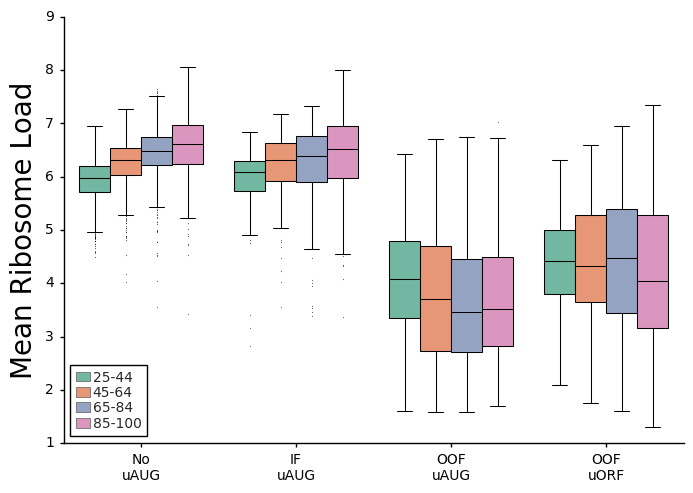

In [33]:
labels = ['None', 'IF uAUG', 'OOF uAUG', 'uORF']
codon = 'AUG'
ax = sns.boxplot(y='rl',x='simple_uaug_status_text',hue = 'rng', data=e_test, order=labels,palette=sns.color_palette("Set2", 4),
                linewidth=1, boxprops={'edgecolor':'black','linewidth':0.75}, medianprops={'color':'black', 'linewidth':0.75},
                whiskerprops={'color':'black', 'linewidth':0.75}, flierprops={'markerfacecolor':'black', 'markersize':0.75,
                                                                           'linestyle':'none'}, capprops={'color':'black', 'linewidth':0.75})

ax.get_lines()
f = ax.get_figure()

#f.set_size_inches((2,2))
labels = ['No\nuAUG', 'IF\nuAUG', 'OOF\nuAUG', 'OOF\nuORF']
ax.set_xticklabels(labels, rotation=0,horizontalalignment='center')
ax.set_ylabel('Mean Ribosome Load', size=20)
ax.set_xlabel('', size=0)
ax.tick_params(axis='x', which='major', top=False, bottom=True, labelbottom=True, length=3, pad=4, labelsize=10, width=1)
ax.tick_params(axis='y', which='major', right=False, length=3, pad=4, labelsize=10, width=1)
legend = ax.legend(loc='lower left', ncol=1, labelspacing=0.1, frameon=True, handlelength=1,handletextpad=0.2)
frame = legend.get_frame()
frame.set_linewidth(1)
frame.set_edgecolor('black')
sns.despine()